In [1]:
# Bi-directional LSTM

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import ConvLSTM2D

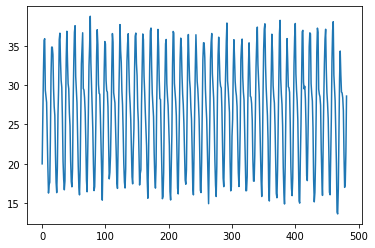

In [3]:
# load the dataset
dataframe = read_csv('rnntime.csv', usecols=[1])
plt.plot(dataframe)


In [4]:
#Convert pandas dataframe to numpy array
dataset = dataframe.values
dataset = dataset.astype('float32') #COnvert values to float


In [5]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) 
dataset = scaler.fit_transform(dataset)

In [6]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]



In [7]:

def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)



print("Shape of training set: {}".format(trainX.shape))
print("Shape of test set: {}".format(testX.shape))


Shape of training set: (374, 10)
Shape of test set: (86, 10)


In [8]:
#Bidirectional LSTM

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

#For some sequence forecasting problems we may need LSTM to learn
# sequence in both forward and backward directions



from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
print('Train...')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100)              24400     
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________
Train...


2021-11-14 22:14:42.861808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-14 22:14:42.868836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2021-11-14 22:14:42.869023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2021-11-14 22:14:42.869185: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-11-14 22:14:42.869336: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could no

In [9]:
model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=100)


Epoch 1/100
12/12 - 2s - loss: 0.2552 - val_loss: 0.1920 - 2s/epoch - 126ms/step
Epoch 2/100
12/12 - 0s - loss: 0.1476 - val_loss: 0.1174 - 32ms/epoch - 3ms/step
Epoch 3/100
12/12 - 0s - loss: 0.0973 - val_loss: 0.0957 - 30ms/epoch - 2ms/step
Epoch 4/100
12/12 - 0s - loss: 0.0792 - val_loss: 0.0790 - 34ms/epoch - 3ms/step
Epoch 5/100
12/12 - 0s - loss: 0.0628 - val_loss: 0.0626 - 30ms/epoch - 3ms/step
Epoch 6/100
12/12 - 0s - loss: 0.0499 - val_loss: 0.0506 - 34ms/epoch - 3ms/step
Epoch 7/100
12/12 - 0s - loss: 0.0394 - val_loss: 0.0408 - 30ms/epoch - 3ms/step
Epoch 8/100
12/12 - 0s - loss: 0.0311 - val_loss: 0.0336 - 39ms/epoch - 3ms/step
Epoch 9/100
12/12 - 0s - loss: 0.0253 - val_loss: 0.0283 - 35ms/epoch - 3ms/step
Epoch 10/100
12/12 - 0s - loss: 0.0212 - val_loss: 0.0248 - 34ms/epoch - 3ms/step
Epoch 11/100
12/12 - 0s - loss: 0.0185 - val_loss: 0.0226 - 36ms/epoch - 3ms/step
Epoch 12/100
12/12 - 0s - loss: 0.0168 - val_loss: 0.0208 - 38ms/epoch - 3ms/step
Epoch 13/100
12/12 - 0s -

In [10]:
# make predictions

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)


In [11]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [12]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))


Train Score: 1.20 RMSE
Test Score: 1.44 RMSE


In [13]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict)+seq_size, :] = trainPredict


In [14]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(seq_size*2)+1:len(dataset)-1, :] = testPredict


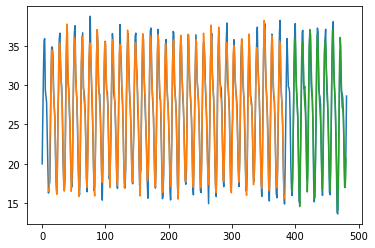

In [15]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [16]:
# Train Score: 1.20 RMSE
# Test Score: 1.44 RMSE
